In [1]:
import torch
import torch.random as random
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import IterableDataset, Dataset, DataLoader
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from split_MNIST import SplitMNIST
# Enable gpu acceleration if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)

In [2]:
train_dataset = SplitMNIST()
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=train_dataset.transform, target_transform=torch.tensor)

In [3]:
class ReplayCNN(nn.Module):
    def __init__(self, input_features, hidden_features, conv_depth, ff_depth, classes, dropout=0.1, max_replay=256):
        super(ReplayCNN, self).__init__()
        self.max_replay = max_replay
        self.feature_extractor = nn.Sequential()
        for i in range(conv_depth):
            in_features = input_features if i == 0 else hidden_features
            out_features = hidden_features
            self.feature_extractor.append(nn.Conv2d(in_features, out_features, kernel_size=3, padding=1, padding_mode='reflect'))
            self.feature_extractor.append(nn.ReLU())
            self.feature_extractor.append(nn.Dropout(dropout))
            self.feature_extractor.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature_extractor.append(nn.AdaptiveAvgPool2d((2, 2)))
        self.feature_extractor.append(nn.Flatten())
        self.classifier = nn.Sequential()
        for i in range(ff_depth):
            in_features = hidden_features * 2 * 2 if i == 0 else hidden_features
            out_features = hidden_features
            self.classifier.append(nn.Linear(in_features, out_features))
            self.classifier.append(nn.ReLU())
            self.classifier.append(nn.Dropout(dropout))
        self.classifier.append(nn.Linear(hidden_features, classes))

        self.replay_buffer = []
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        self.kd_criterion = nn.MSELoss()
        self.eval()
    
    def add_experience(self, input, target):
        self.eval()
        with torch.no_grad():
            output = self(input.unsqueeze(0))    
        if len(self.replay_buffer) > self.max_replay:
            idx = np.random.randint(0, len(self.replay_buffer))
            self.replay_buffer[idx] = (input, target, output)
        else:
            self.replay_buffer.append((input, target, output))
    
    def _get_replay_buffer_as_tensor(self):
        if len(self.replay_buffer) == 0:
            return None
        inputs, targets, old_outputs = zip(*self.replay_buffer)
        inputs = torch.stack(inputs)
        targets = torch.stack(targets)
        old_outputs = torch.cat(old_outputs, dim=0)
        return inputs, targets, old_outputs

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
    
    def replay(self):
        batch = self._get_replay_buffer_as_tensor()
        if batch is None:
            return
        self.optimizer.zero_grad()
        inputs, targets, old_outputs = batch
        outputs: torch.Tensor = self(inputs)
        accuracy: torch.Tensor = (outputs.argmax(dim=1) == targets).float().mean()
        loss: torch.Tensor = self.criterion(outputs, targets) + 0.1 * self.kd_criterion(outputs, old_outputs)
        loss.backward()
        self.optimizer.step()
        return loss.item(), accuracy.item()

    def fit(self, train_dataset: IterableDataset, test_dataset: Dataset):
        test_batch_size = 256
        self.train()
        loading_bar = tqdm(train_dataset, desc="Training", total=len(train_dataset))
        for item in loading_bar:
            x, y, task = item
            x = x.to(device)
            y = y.to(device)
            self.add_experience(x, y)
            loss, accuracy = self.replay()
            loading_bar.set_postfix(loss=loss, accuracy=f"{accuracy:.2%}")
        test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, generator=torch.Generator(device=device))
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            loading_bar = tqdm(test_loader, desc="Testing", total=len(test_loader))
            confusion_matrix = torch.zeros(10, 10, dtype=torch.int64)
            for x, y in loading_bar:
                x = x.to(device)
                y = y.to(device)
                outputs = self(x)
                total += y.shape[0]
                correct += (outputs.argmax(dim=1) == y).sum().item()
                accuracy = correct / total
                confusion_matrix += torch.bincount(y * 10 + outputs.argmax(dim=1), minlength=100).reshape(10, 10)
                loading_bar.set_postfix(accuracy=f"{accuracy:.2%}")
        plt.figure(figsize=(10, 10))
        plt.imshow(confusion_matrix.cpu(), interpolation='nearest')
        plt.colorbar()
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.xticks(np.arange(10))
        plt.yticks(np.arange(10))
        plt.show()


In [4]:
model = ReplayCNN(input_features=1, hidden_features=32, conv_depth=2, ff_depth=2, classes=10, dropout=0.1, max_replay=1024)


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

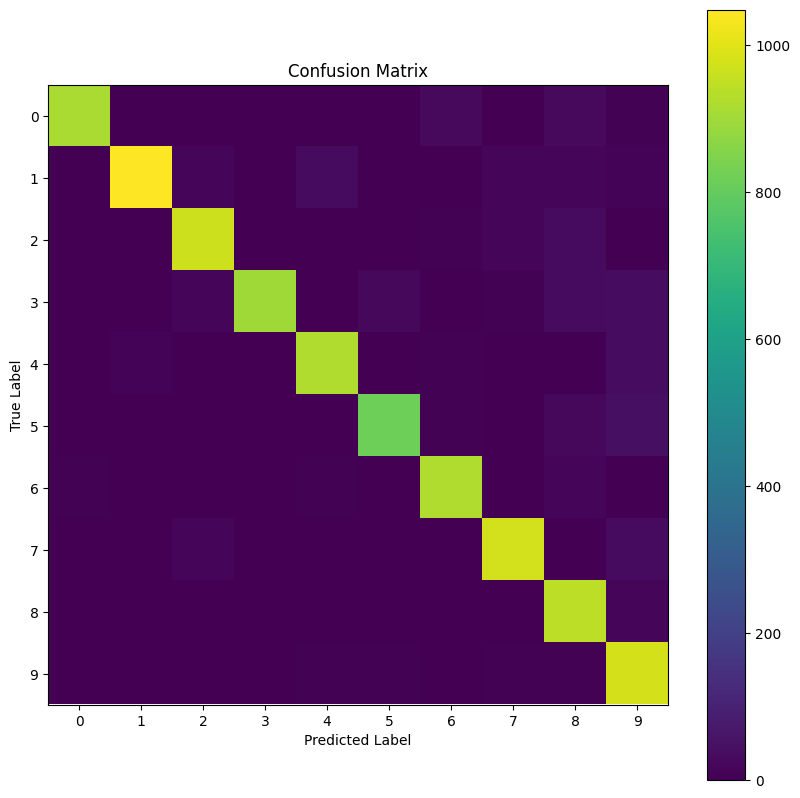

In [5]:
model.fit(train_dataset, test_dataset)